## Todos

- calculate centrality measure only once
- replace randomize_graph in basic_graph_analyzer.py by utils function

In [1]:
from src.analysis.basic_graph_analyzer import BasicGraphAnalyzer
from src.analysis.centrality_analyzer import CentralityAnalyzer
from src.analysis.scale_free_analyzer import ScaleFreeAnalyzer


In [2]:
from graph_tool import openmp_set_num_threads

# Set the number of threads to use
openmp_set_num_threads(8)

In [3]:
from graph_tool.all import load_graph

file_path = 'outputs/graphs/Machine_learning.gt'

G = load_graph(file_path)

num_nodes = G.num_vertices()
num_edges = G.num_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")

Number of nodes: 75217
Number of edges: 26149964


In [ ]:
from graph_tool.draw import sfdp_layout
from graph_tool.draw import graph_draw

pos = sfdp_layout(G)
graph_draw(G, pos)


Processing vertices: 100%|██████████| 75217/75217 [02:15<00:00, 556.49vertex/s]


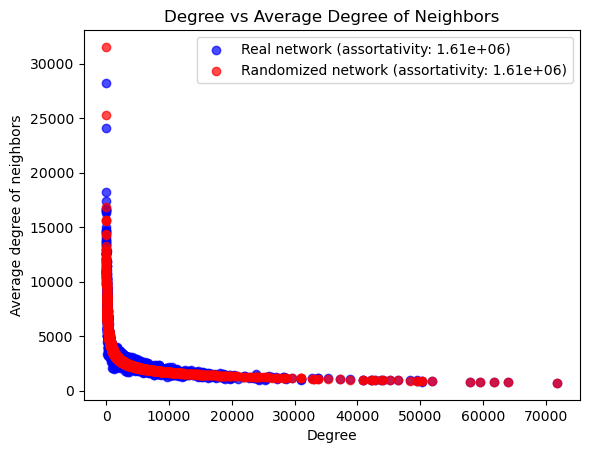

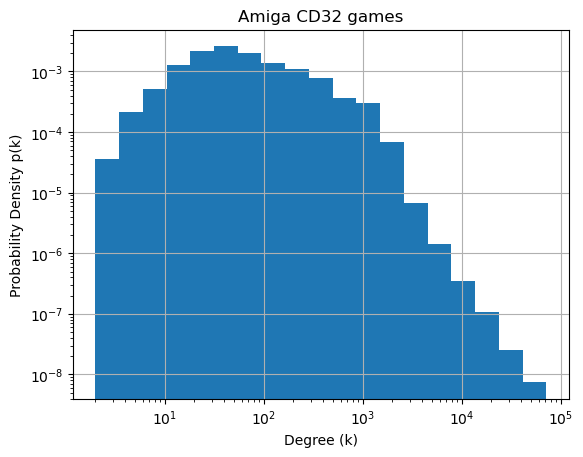

In [4]:
basic_graph_analyzer = BasicGraphAnalyzer(G)
basic_graph_analyzer.plot_degree_vs_avg_degree("Degree vs Average Degree of Neighbors", plot_randomized=True)
basic_graph_analyzer.plot_log_log_probability_density('Machine learning')

In [ ]:
centrality_analyzer = CentralityAnalyzer(G)
centrality_analyzer.plot_centralities()
centrality_analyzer.plot_centralities_comparison()
centrality_analyzer.plot_centralities_comparison_randomized()

Calculating degrees...
Degrees calculated in 0.00 seconds.

Calculating eigenvector...
Eigenvector centrality calculated in 1.64 seconds.

Calculating closeness...


--------------------------------------------------
Calculating best minimal value for power law fit
xmin progress: 99%

Exponent: 2.620487032965556
Error: 0.03449406628647547
-------------------- Graph: Machine learning --------------------
Graph average degree: 695.3205791244001
Graph max degree: 71792
Graph min degree: 2
-----------------------------------------------------------------


/Users/dariokuffer/Projects/Studium/Project-Network-Science-HS24/src/analysis/scale_free_analyzer.py:15: RuntimeWarning: overflow encountered in power
  y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)
/Users/dariokuffer/Projects/Studium/Project-Network-Science-HS24/src/analysis/scale_free_analyzer.py:15: RuntimeWarning: invalid value encountered in divide
  y = np.exp(-lamda) * np.power(lamda, x) / special.factorial(x)


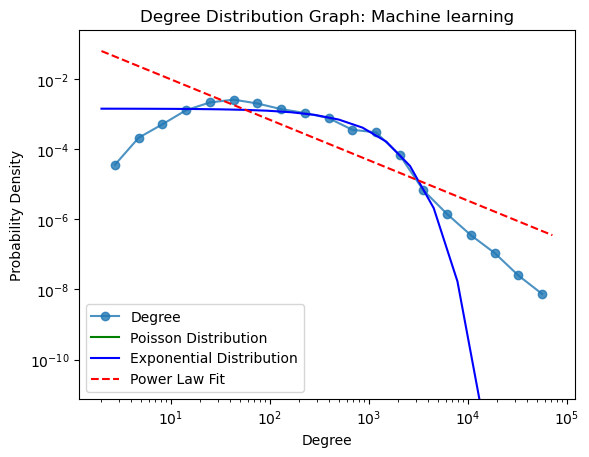

In [5]:
scale_free_analyzer = ScaleFreeAnalyzer(G)
scale_free_analyzer.calculate_power_law_degree_distributio()
scale_free_analyzer.plot_degree_distribution(G, 'Machine learning')